In [86]:
#importing libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import learning_curve, GridSearchCV  #Perforing grid search
from sklearn.model_selection import cross_validate
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split 


import warnings
warnings.filterwarnings("ignore")

In [87]:
dataset = pd.read_csv('../data/child_master_file.csv')

In [88]:
selectedCategoricalColumns = ['age_group','w5_best_marstt','educat','w5_geo2011','w5_best_race','w5_empl_stat',
                   'w5_hhead_gen','water_source','w5_h_enrgelec','cooking_energy','hhsize_grp','w5_h_dwltyp']

selectedNumericalColumns = ['v101', 'v102', 'v103', 'v104', 'v105', 'v106', 'v107', 'v108', 'v109',
       'v110', 'v113', 'v116', 'v130','v132','v133','v139','v146']

In [89]:
target = dataset['died'].astype('int')

selectedCategories = dataset[selectedCategoricalColumns].astype('O')

selectedNumerics = dataset[selectedNumericalColumns].astype('int64','float64')

selectedDataset = selectedCategories.join(selectedNumerics, how='outer')

categoricals = selectedDataset.select_dtypes(include='object')
# Take k-1 dummies out of k categorical levels, drop_first set to true
categoricals = pd.get_dummies(categoricals,drop_first=True)#,drop_first=True
#numerics can be normalized separately
numerics = selectedDataset.select_dtypes(include=['int64','float64'])
selectedDataset = categoricals.join(numerics)
selectedDataset.head()

dataset = selectedDataset.join(target, how='outer')

In [90]:
def underSample_dataPrepation(df):
    #-counts the distribution of target variable
    target_count = df.died.value_counts()
    y = df.loc[:, 'died']
    X = df.iloc[:, 0:dataset.shape[1]-1]
    df_class_0 = df[df['died'] == 0]
    df_class_1 = df[df['died'] == 1]
    #-oversampling the lowest class to make it equivalent to the majority class
    df_class_0_under = df_class_0.sample(target_count[1], replace=True)
    #-concatenate the targets after oversampling
    data_train = pd.concat([df_class_1, df_class_0_under], axis=0)
    target_count_2 = data_train.died.value_counts()
    print('Class 0:', target_count_2[0])
    print('Class 1:', target_count_2[1])
    print('Proportion:', round(target_count_2[0] / target_count_2[1], 2), ': 1')
    
    x_labels = data_train.loc[:, 'died']
    x_features = data_train.iloc[:, 0:dataset.shape[1]-1]
    x_features_train,x_features_test,x_labels_train,x_labels_test = train_test_split(x_features,x_labels,test_size=0.3)
    
    print("length of training data")
    print(len(x_features_train))
    print("length of test data")
    print(len(x_features_test))
    
    return (data_train, x_features_train, x_features_test, x_labels_train, x_labels_test)
dataset, train_df, test_df, target, target_real = underSample_dataPrepation(dataset)

Class 0: 149
Class 1: 149
Proportion: 1.0 : 1
length of training data
208
length of test data
90


In [91]:
X = dataset.iloc[:,:-1]
y = dataset['died'].values

In [92]:
def modelfit(alg, train_df,target,test_df,target_real,useTrainCV=True, cv_folds=10, early_stopping_rounds=250):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_df.values, label=target.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train_df, target, eval_metric='auc')
        
    #Predict training set:
    y_pred = alg.predict(test_df)
    y_predprob = alg.predict_proba(test_df)[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target_real.values, y_pred))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(target_real, y_predprob))
    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
    return y_pred, y_predprob, alg

In [93]:
#set the parameters
xgb1 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=20,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
y_pred, y_predprob, clf  = modelfit(xgb1,train_df,target,test_df,target_real)


Model Report
Accuracy : 0.5556
AUC Score (Train): 0.549160


In [94]:
import collections
collections.Counter(y_pred)

Counter({1: 48, 0: 42})

In [95]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(target_real.values, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
confusion

array([[23, 21],
       [19, 27]], dtype=int64)

In [96]:
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, target_real.values)
accuracy

0.5555555555555556

##### Sensitivity: When the actual value is positive, how often is the prediction correct?

How "sensitive" is the classifier to detecting positive instances?
Also known as "True Positive Rate" or "Recall"

In [97]:
from sklearn import metrics
print(TP / float(TP + FN))
print(metrics.recall_score(target_real.values, y_pred))

0.5869565217391305
0.5869565217391305


#### Specificity: When the actual value is negative, how often is the prediction correct?

How "specific" (or "selective") is the classifier in predicting positive instances?

In [98]:
print(TN / float(TN + FP))

0.5227272727272727


0.5491600790513834


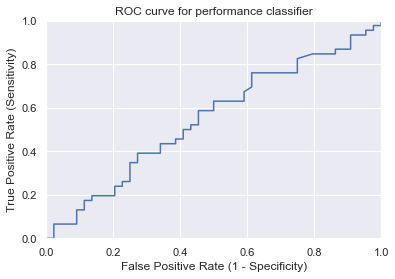

In [99]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(target_real.values, y_predprob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for performance classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(metrics.roc_auc_score(target_real.values, y_predprob))

### SHAP values

In [100]:
import shap

explainer = shap.TreeExplainer(clf)

In [101]:
shap_values = explainer.shap_values(test_df.iloc[:test_df.shape[0],:])
shap_values.shape

shap_values = shap.TreeExplainer(clf).shap_values(test_df.iloc[:test_df.shape[0],:])
shap_values.shape

global_importances = np.abs(shap_values).mean(0)[:-1]

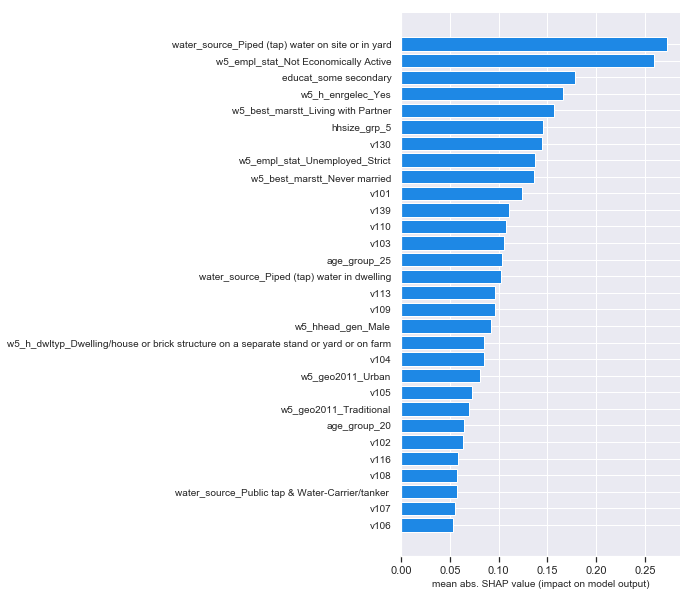

In [103]:
# make a bar chart that shows the global importance of the top 20 features
inds = np.argsort(-global_importances)
f = plt.figure(figsize=(5,10))
y_pos = np.arange(30)
inds2 = np.flip(inds[:30], 0)
plt.barh(y_pos, global_importances[inds2], align='center', color="#1E88E5")
plt.yticks(y_pos, fontsize=10)
plt.gca().set_yticklabels(train_df.columns[inds2])
plt.xlabel('mean abs. SHAP value (impact on model output)', fontsize=10)
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('none')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('../images/featureimportance.png', bbox_inches='tight')